## NECESSARY IMPORTS AND VARIABLES

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras, data
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import os, cv2, time
from functools import partial
from albumentations import (Compose, HorizontalFlip, RandomRotate90, MotionBlur)
from keras.backend import clear_session
#import optuna
#import optuna.visualization as optvis

from sklearn.model_selection import KFold

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

import os
import cv2
from PIL import Image
import numpy as np

In [ ]:
batch_size = 16
img_height = 224
img_width = 224
SIZE = 224
num_channels = 3 # RGB
#labels = ['No_Billboard', 'Billboard']
INPUT_SHAPE = (img_height, img_width)
SHAPE = (img_height, img_width, num_channels)

data_dir_path = "/python_programming/FYP_2022/billboard_dataset/output1/"

dataset = []  #Many ways to handle data, you can use pandas.
label = []  #Place holders to define add labels. We will add 0 to all no_billboards  images and 1 to billboards.


## LOADING IN THE DATA

In [ ]:
no_bilboard_images = os.listdir(data_dir_path + 'No_Billboard/')
for i, image_name in enumerate(no_bilboard_images):    #Remember enumerate method adds a counter and returns the enumerate object

    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'No_Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1
billboard_images = os.listdir(data_dir_path + 'Billboard/')
for i, image_name in enumerate(billboard_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset = np.array(dataset)
label = np.array(label)

(3020, 224, 224, 3)
(3020,)
Label for this image is:  0


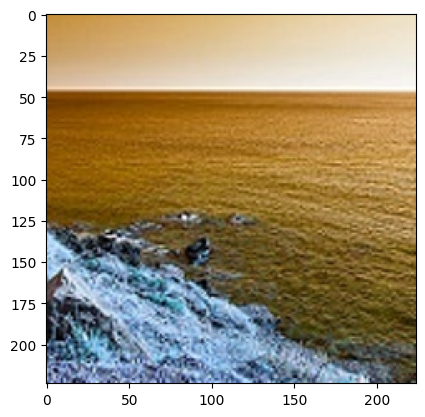

In [ ]:
print(dataset.shape)
print(label.shape)


#Sanity check, view random few mages
import random
import numpy as np
image_number = random.randint(0, len(dataset)-1)
plt.imshow(np.reshape(dataset[image_number], (224, 224, 3)))
print("Label for this image is: ", label[image_number])

In [ ]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#from keras.utils import normalize
#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)
X_train = X_train / 255.
X_test = X_test / 255.

#Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0) #labels

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

## TRAINING MODEL

In [ ]:
model_save_name = 'ADNetclassifierkfold.pt'
path = f"/python_programming/FYP_2022/Models/{model_save_name}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    verbose= 1,
    filepath=path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
ADNET_model = tf.keras.models.Sequential()
ADNET_model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu',  input_shape=SHAPE))
ADNET_model.add(tf.keras.layers.MaxPooling2D(2, 2))
ADNET_model.add(
    tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=3,
        strides=1,
        activation="relu"
    )
)
ADNET_model.add(tf.keras.layers.MaxPooling2D(2, 2)),
ADNET_model.add(tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=3,
        strides=1,
        activation="relu",
        name="visualising_layer"
))

ADNET_model.add(tf.keras.layers.MaxPooling2D(2, 2))
ADNET_model.add(keras.layers.Flatten())
ADNET_model.add(keras.layers.Dense(units=1024, activation='relu'))
ADNET_model.add(keras.layers.Dropout(0.5))
#ADNET_model.add(keras.layers.Dense(1, activation="sigmoid"))#sigmoid--binarycrossentropy
ADNET_model.add(keras.layers.Dense(2, activation="softmax"))#softmax--sparsecategoricalcrossentropy

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
visualising_layer (Conv2D)   (None, 52, 52, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0

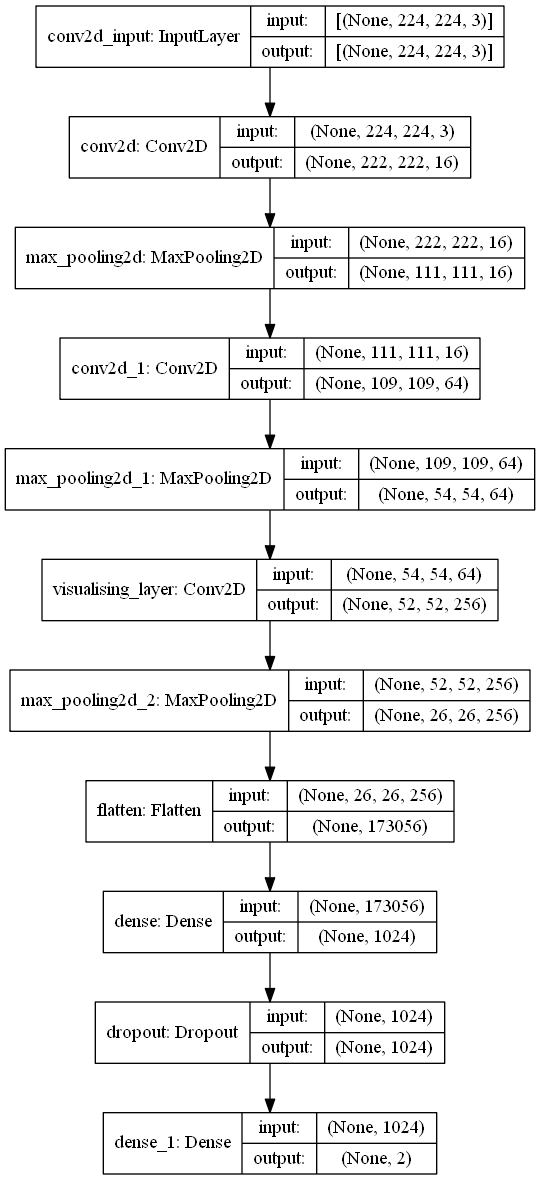

In [ ]:
ADNET_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00225, epsilon = 0.1),
        #loss = tf.keras.losses.BinaryCrossentropy(),#from_logits=True),
        #optimizer='rmsprop',
        metrics=["accuracy"],
    )

print(ADNET_model.summary())
tf.keras.utils.plot_model(ADNET_model, show_shapes=True)#show_shapes=True

In [ ]:
fold_no = 1

num_folds = 10  # Number of splits for k-fold cross-validation
kf = KFold(n_splits=num_folds)

 #train_steps = len(X_train) // batch_size
 #valid_steps = len(X_test) // batch_size

for train, test in kf.split(inputs, targets):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history =ADNET_model.fit(
        X_train, y_train,
        validation_data=(X_test,y_test),
        batch_size=batch_size,
        epochs=50,
        steps_per_epoch=45,
        callbacks=[earlyStopping,model_checkpoint_callback]
    )

    # Generate generalization metrics
    scores = ADNET_model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {ADNET_model.metrics_names[0]} of {scores[0]}; {ADNET_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
45/45 [==============================] - 24s 180ms/step - loss: 0.6479 - accuracy: 0.6042 - val_loss: 0.6642 - val_accuracy: 0.5315

Epoch 00001: val_accuracy improved from -inf to 0.53146, saving model to /python_programming/FYP_2022/Models\ADNetclassifierkfold.pt
Epoch 2/50
45/45 [==============================] - 4s 77ms/step - loss: 0.6329 - accuracy: 0.6597 - val_loss: 0.6260 - val_accuracy: 0.7202

Epoch 00002: val_accuracy improved from 0.53146 to 0.72020, saving model to /python_programming/FYP_2022/Models\ADNetclassifierkfold.pt
Epoch 3/50
45/45 [==============================] - 3s 69ms/step - loss: 0.5946 - accuracy: 0.7431 - val_loss: 0.5879 - val_accuracy: 0.7020

Epoch 00003: val_accuracy did not improve from 0.72020
Epoch 4/50
45/45 [==============================] - 3s 66ms/step - loss: 0.5720 - accuracy: 0.7194 - val_loss: 0.5497 - val_accuracy: 0.7632

Epoch 000

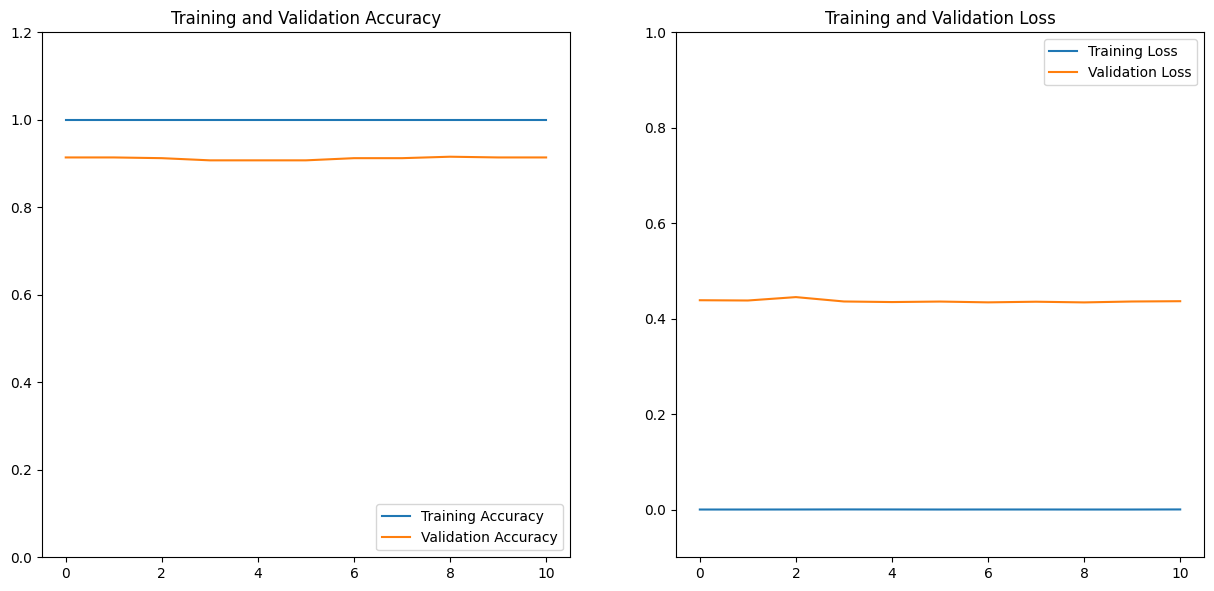

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.ylim(0, 1.2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.ylim(-0.1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## PREDICTIONS AND VISUALISATION OF MISCLASSIFIED IMAGES

In [ ]:
ADNET_model.load_weights(path)

In [ ]:
'''
#Test the model on single images
xtestlen = len(X_test)-1
print('xtestlen:', xtestlen)
n = random.randint(0, xtestlen)
print('n:',n)
img = X_test[n]
actual_ylabel = y_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
'''
predictions = ADNET_model.predict(X_test)
actual_ylabel = y_test

#print("The prediction for this image is: ", predictions)
print("The actual label for this image is: ", actual_ylabel)

y_hat = np.argmax(predictions, axis = 1) # We take the highest probability
print('prediction label:', y_hat)

#Compare the predictions and labels and get the accuracy
accuracy = np.mean(np.equal(actual_ylabel, y_hat))
print(f"Accuracy: {accuracy:.2f}")

The actual label for this image is:  [0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0
 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0
 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1
 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1
 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0
 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0
 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0
 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1
 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1
 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1
 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 

In [ ]:
_, acc = ADNET_model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


19/19 [==============================] - 1s 28ms/step - loss: 0.3096 - accuracy: 0.9172
Accuracy =  91.7218565940857 %


In [ ]:
# Compare y_hat to y_val
misclassified = []
label_comparison =  actual_ylabel == y_hat
misclassified = np.where(label_comparison == False)[0]  # Get the indices of misclassified images
print('misclassified indices:',misclassified)
print('no of missclassification:', len(misclassified))
plt.figure(figsize=(25, 25))
for i, index in enumerate(misclassified):
    ax =plt.subplot(9, 7, i+1)
    plt.imshow(X_test[index])
    plt.title("True label: {} \n Predicted label: {}".format(actual_ylabel[index], y_hat[index]))
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

Calculate evaluation metric: Recall, Precision, Accuracy, F1score

In [ ]:
pre = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()
rootmsqrerror = tf.keras.metrics.RootMeanSquaredError()
auc_roc = tf.keras.metrics.AUC()

In [ ]:
tf.math.confusion_matrix(
    y_test,
    y_hat,
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[254,  31],
       [ 19, 300]])>

In [ ]:
pre.update_state(y_test, y_hat)
rec.update_state(y_test, y_hat)
acc.update_state(y_test, y_hat)
rootmsqrerror.update_state(y_test, y_hat)
auc_roc.update_state(y_test, y_hat)

print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')
print(f'RMSE:{rootmsqrerror.result().numpy()}')
print(f'AUC:{auc_roc.result().numpy()}')

f1_score = 2 * (pre.result().numpy() * rec.result().numpy()) / (pre.result().numpy() + rec.result().numpy())

print(f'F1score:{f1_score}')

Precision:0.9063444137573242, Recall:0.9404388666152954, Accuracy:0.9172185659408569
RMSE:0.28771767020225525
AUC:0.9158334732055664
F1score:0.9230769081808406


Save the model

In [ ]:
path = f"/python_programming/FYP_2022/Models/model/"
ADNET_model.save(os.path.join(path, 'ALOS_ADNET_modelkfold.h5'))

new_model = tf.keras.models.load_model(os.path.join(path, 'ALOS_ADNET_modelkfold.h5'))

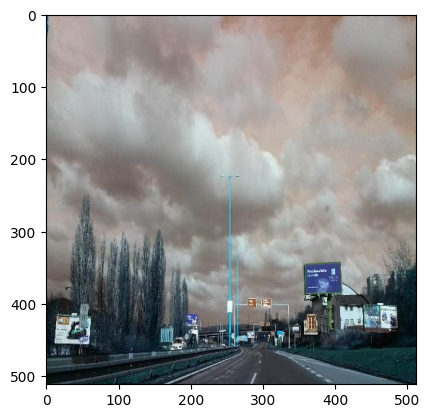

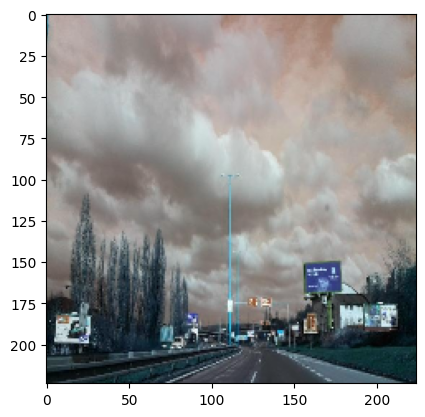

[[0.00735715 0.9926428 ]]
[1]
Predicted class belongs to billboard class


In [ ]:
newtest = cv2.imread('/python_programming/FYP_2022/billboard_dataset/output1/Billboard/scene_1223.jpg')
plt.imshow(newtest)
plt.show()

resize_newtest = cv2.resize(newtest, (224, 224))
plt.imshow(resize_newtest)
plt.show()
pred_newtest = np.expand_dims(resize_newtest/255, 0)
#print(pred_newtest)

y_pred_newtest = new_model.predict(pred_newtest)
print(y_pred_newtest)
y_pred_newtest = np.argmax(y_pred_newtest, axis = 1)
print(y_pred_newtest)

if y_pred_newtest > 0.5:
  print('Predicted class belongs to billboard class')

else:
  print('Predicted class belongs to no billboad class')